In [7]:
import numpy as np
import matplotlib.pyplot as plt

#### Helper methods

In [8]:
def plot_data(data_pred, data_true=None):
    X_pred, Y_pred = data_pred
    plt.plot(X_pred, Y_pred, c='r', label='Predicted values')
    
    if data_true is not None:
        X_true, Y_true = data_true
        plt.plot(X_true, Y_true, c='b', alpha=0.6, label='Expected values')
        plt.title('Prediction MSE: %.5f (True var: %.5f)' % (compute_mse(Y_pred, Y_true), Y_true.var()))
        
    plt.grid()
    plt.legend()
    plt.show()
    
def compute_mse(predicted, true):
    return np.sum(np.square(predicted - true)) / predicted.shape[0]
    
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [19]:
class EchoStateNet(object):
    """
    Notation based on: http://www.scholarpedia.org/article/Echo_state_network
    """
    def __init__(self, res_size=1000):
        self._res_size = res_size
        self._in_size = None
        self._out_size = None
        
        self._Win = None
        self._Wres = None
        self._Wout = None
        
        self._prev_x = None
        self._prev_y = None
        
    def _compute_reservoir_state(self, u):
        return np.tanh(self._Wres.dot(self._prev_x) + 
                       self._Win.dot(u) + 
                       self._Wfb.dot(self._prev_y))
        
    def _harvest_reservoir(self, U, Y, add_noise=True):
        X = np.zeros((U.shape[0], self._res_size))
        
        self._prev_x = np.zeros(self._res_size)
        self._prev_y = np.zeros(self._out_size)
        
        for n, (u, y) in enumerate(zip(U, Y)):
            x = self._compute_reservoir_state(u)
            
            # adding noise works as regularization
            if add_noise:
                x += np.random.normal(scale=1e-3, size=(self._res_size,))
                
            X[n,:] = x
            self._prev_x = x
            self._prev_y = y
        return X
    
    def train(self, U, Y):
        # add bias to U
        U = np.hstack((np.ones(U.shape), U))
        
        self._in_size = U.shape[1]
        self._out_size = Y.shape[1]
        
        # initialize input and reservoir weight matrices
        self._Win = np.random.rand(self._res_size, self._in_size) - 0.5
        self._Wres = np.random.rand(self._res_size, self._res_size) - 0.5
        self._Wfb = np.random.rand(self._res_size, self._out_size) - 0.5
        
        # normalize reservoir weights
        rhoW = np.max(np.abs(np.linalg.eig(self._Wres)[0]))
        self._Wres *= 1.25 / rhoW
        
        # set starting point and harvest reservoir
        X = self._harvest_reservoir(U, Y)
        S = np.hstack((U, X))
        
        # learn output weights
        self._Wout = np.linalg.pinv(S).dot(Y).T
    
    def predict(self, u):
        # augment u with bias ter
        u = np.hstack((np.ones(u.shape), u))
        
        # perform computation
        x = self._compute_reservoir_state(u)
        z = np.hstack((u, x))
        y = self._Wout.dot(z)
        
        # update network state
        self._prev_x = x
        self._prev_y = y
        
        return y
    
    def generate(self, u_start, steps=100):
        Y = np.empty(steps, self._out_size)
        u = np.hstack((u, np.ones(u.shape)))
        x = self._compute_reservoir_state(u)
        z = np.hstack((u, x))
        y = self._Wout.dot(z)
        for idx in xrange(steps):
            
            pass

### Mackey data set

In [20]:
# load and split data
data = np.array(np.loadtxt('MackeyGlass_t17.txt')).reshape(-1, 1)
data = data[:4000]

train_size = 2500
data_train = data[:train_size]
data_test = data[train_size:]

# initialize and train echo state network
esnet = EchoStateNet()
esnet.train(data_train[:-1], data_train[1:])

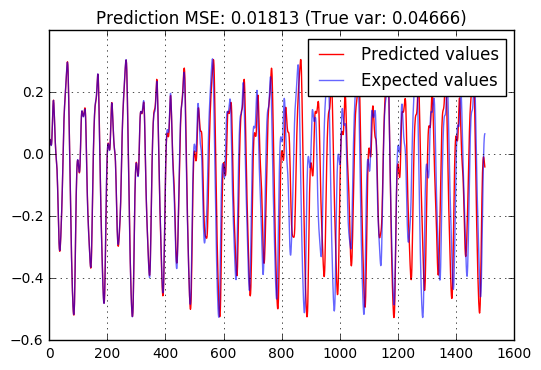

In [21]:
# generate data
data_pred = np.empty(data_test.shape)
y_t = data_train[-1]

for idx in xrange(data_test.shape[0]):
    y = esnet.predict(y_t)
    data_pred[idx, :] = y
    y_t = y

T = range(data_test.shape[0])
plot_data((T, data_pred), (T, data_test))

### Sinus data set

In [101]:
T = np.linspace(0, 10*np.pi, 500)
mult_train = np.array([1]*500 + [2]*500 + [0.5]*500).reshape(-1, 1)
data_train = np.hstack((np.sin(T),np.sin(2*T), np.sin(0.5*T))).reshape(-1, 1)

esnet = EchoStateNet()
esnet.train(mult, data)

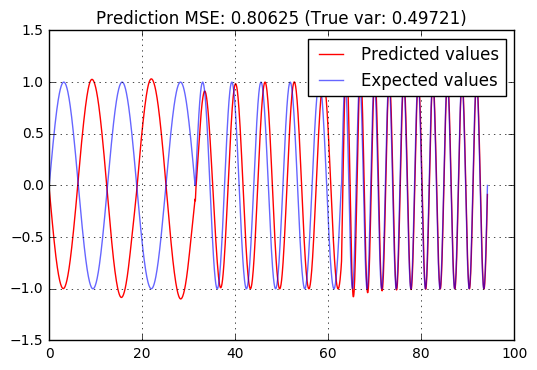

In [102]:
T = np.linspace(0, 10*np.pi, 500)
mult_test = np.array([0.5]*500 + [1]*500 + [2]*500).reshape(-1, 1)
data_test = np.hstack((np.sin(0.5*T),np.sin(1*T), np.sin(2*T))).reshape(-1, 1)

X = np.linspace(0, 30*np.pi, 1500)
data_pred = np.array([esnet.predict(m) for m in mult_test])
plot_data((X, data_pred), (X, data_test))